In [72]:
import sys 
sys.path.append(os.path.abspath(".."))
from src.models.EmoBaseline import EmoBaseline
from src.models.EmoLSTM import EmoLSTM

import os 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import tomllib
import json
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report
from collections import defaultdict

In [32]:
def load_glove_embeddings(path, word2idx, embedding_dim=100):
    """
    path: path to glove.6B.100d.txt
    word2idx: dictionary mapping words to integers from your dataset
    """
    vocab_size = len(word2idx)
    # Initialize matrix with random values (or zeros)
    embedding_matrix = torch.randn(vocab_size, embedding_dim)
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = torch.tensor([float(x) for x in values[1:]])
                idx = word2idx[word]
                embedding_matrix[idx] = vector

    return embedding_matrix


# Evaluation and Metrics
I evaluated the two models with the following metrics:
- Validation Loss (Weighted Cross Entropy) is the loss computed over the set, during each epoch after training
- Top-2 Validation Accuracy is the accuracy computed over the top 2 highest probability guesses. In my case both Validation Accuracy and Top-2 Val Accuracy are high, so the model is confident. But Top-2 Val Accuracy is higher.
- F1 Score is a metric that combines precision and recall, and it is used in cases where the data is unbalanced
- F1 Score can be weighted and not weighted. The not weighed (macro) is lower but a more honest evaluation because it does not take in account that data is unbalanced.
- MCC gives an high scores when the model is generally good at: correctly finding positives (TP), correctly finding negatives (TN), avoiding false positives (FP) and avoiding false negatives (FN). It is computed as:

$$MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$

In [66]:
# Load dataset
dataset_path = "../data/datasets/final/dataset.parquet"
df = pd.read_parquet(dataset_path)
distributions=df['emotions'].value_counts(normalize=True)

# Load vocabulary
vocabulary_path = "../data/vocab.json"
with open(vocabulary_path, 'r', encoding='utf-8') as f:
    word2idx = json.load(f)

idx2word = {}
for k,v in word2idx.items():
    idx2word[v] = k

# Load TOML configuration for Hyperparameters
load_path_toml = "../config.toml"
def load_config(path=load_path_toml):
    with open(path, "rb") as f:
        return tomllib.load(f)

config = load_config()

embedding_dim = config["project"]["embedding_dim"]
output_dim = config["project"]["output_dim"]
epoch_num = config["project"]["epoch_num"]
hidden_dim_base = hidden_dim = config["model"]["baseline"]["hidden_dim"]

# Load Glove Weights
glove_path = '../data/glove/glove.6B.300d.txt'
weights = load_glove_embeddings(glove_path, word2idx, embedding_dim=embedding_dim)

# Recreate object for EmoBaseline class
model_base = EmoBaseline(len(word2idx), # Dict
                                       embedding_dim,
                                       hidden_dim_base,
                                       output_dim,
                                       weights, # Glove Weights
                                       distributions=list(distributions) # Prior Initialization
                                       )


# Path to the .pt baseline model
baseline_path = "../models/best_model_baseline_v1_f1_0.8627.pt"

# Load model on the CPU
loaded = torch.load(baseline_path, map_location=torch.device('cpu') )
model_base.load_state_dict(loaded['model_state_dict'])

last_epoch = loaded['epoch']
history_base = loaded['history']

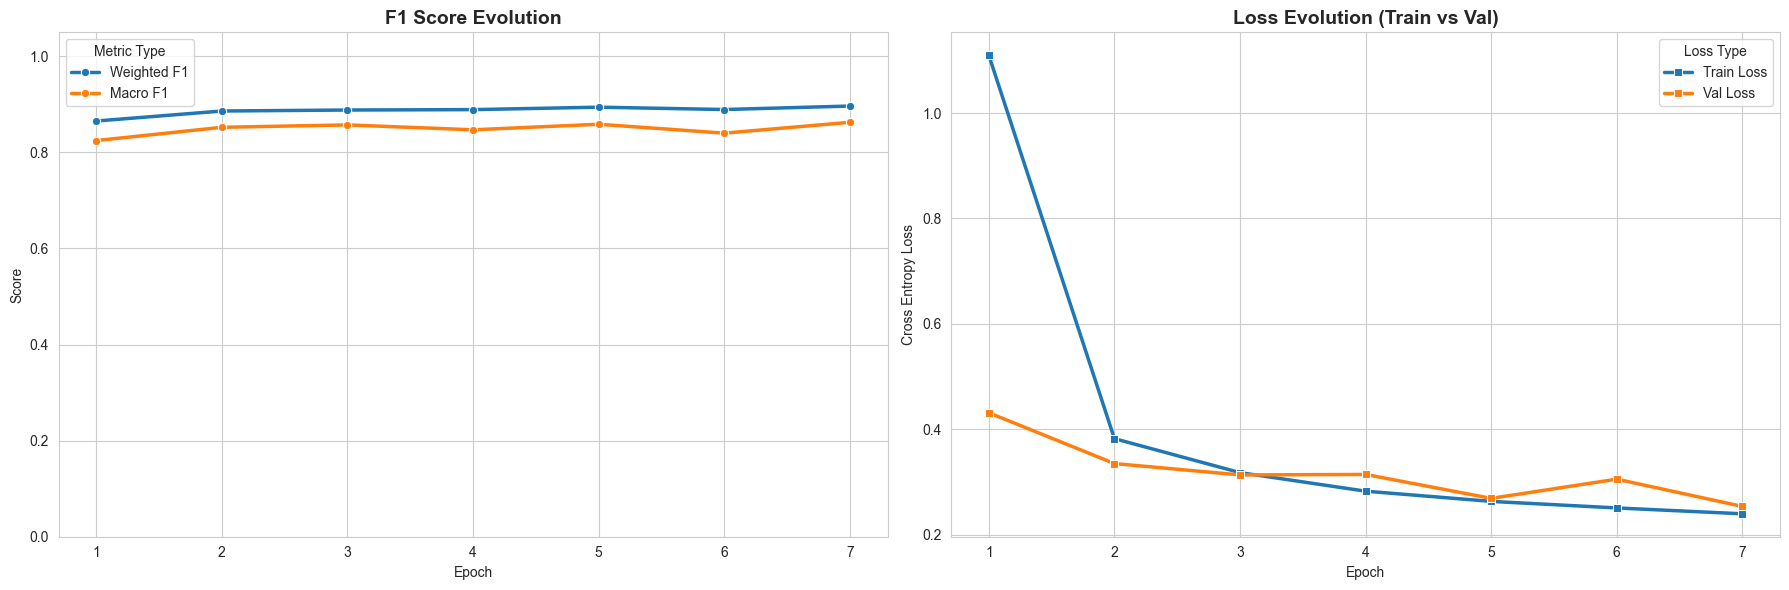

In [34]:
# Prepare data for F1 Score
epochs = range(1, last_epoch + 1)
df_f1 = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_base['weighted'] + history_base['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_base['train_loss'] + history_base['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# Plot
plt.tight_layout()
plt.show()

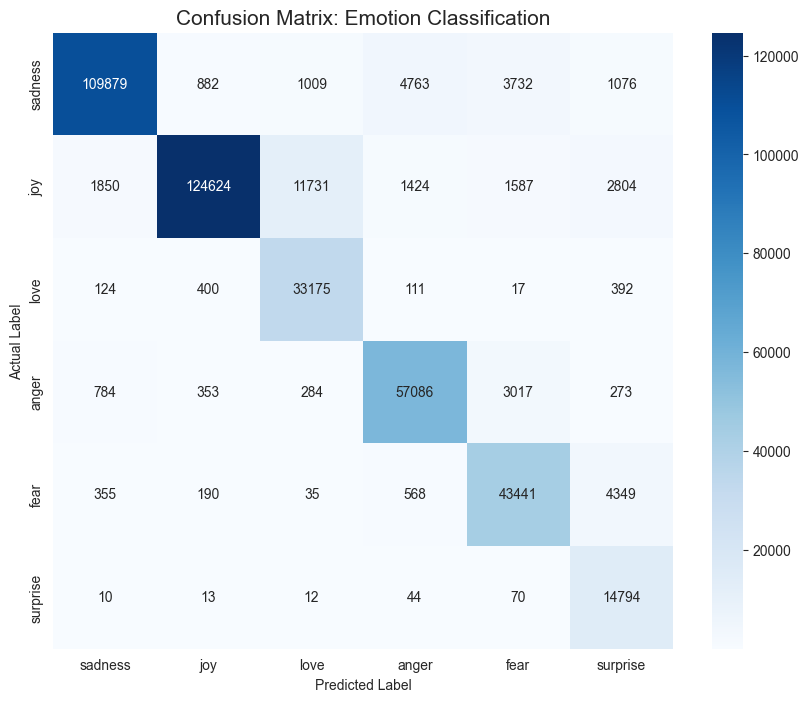

Classification Report 
               precision    recall  f1-score   support

     sadness       0.97      0.91      0.94    121341
         joy       0.99      0.87      0.92    144020
        love       0.72      0.97      0.82     34219
       anger       0.89      0.92      0.91     61797
        fear       0.84      0.89      0.86     48938
    surprise       0.62      0.99      0.77     14943

    accuracy                           0.90    425258
   macro avg       0.84      0.92      0.87    425258
weighted avg       0.92      0.90      0.90    425258

Matthews Correlation Coefficient: 0.8741179595958781


In [36]:
def plot_cm(all_labels, all_preds, emotions_list):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    # Use fmt='d' for integers, cmap='Blues' for clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions_list,
                yticklabels=emotions_list)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: Emotion Classification', fontsize=15)
    plt.show()

# Use it after your final validation call
all_labels = df['label']

model_base.eval()

def get_all_preds(data_row, model):
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0)

    with torch.no_grad():
      output = model(input_tensor)
      predicted_idx = torch.argmax(output, dim=1).item()
    return predicted_idx

all_preds= df.apply(lambda row: get_all_preds(row, model_base), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)


# Classification report
cr = classification_report(all_labels, all_preds, target_names=target_labels)
print(f"Classification Report \n {cr}")

# Matthews Correlation Coefficient (MCC)
mc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient: {mc}") # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

In [44]:
hidden_dim_lstm = hidden_dim = config["model"]["lstm"]["hidden_dim"]

# Recreate object for EmoLSTM class
model_lstm = EmoLSTM(len(word2idx), # Dict
                                       embedding_dim,
                                       hidden_dim_lstm,
                                       output_dim,
                                       weights, # Glove Weights
                                       distributions=list(distributions) # Prior Initialization
                                       )

# Path to the .pt baseline model
lstm_path = "../models/best_model_lstm_attn_v1_f1_0.9101.pt"

# Load model on the CPU
loaded = torch.load(lstm_path, map_location=torch.device('cpu') )
model_lstm.load_state_dict(loaded['model_state_dict'])

last_epoch = loaded['epoch']
history_lstm = loaded['history']


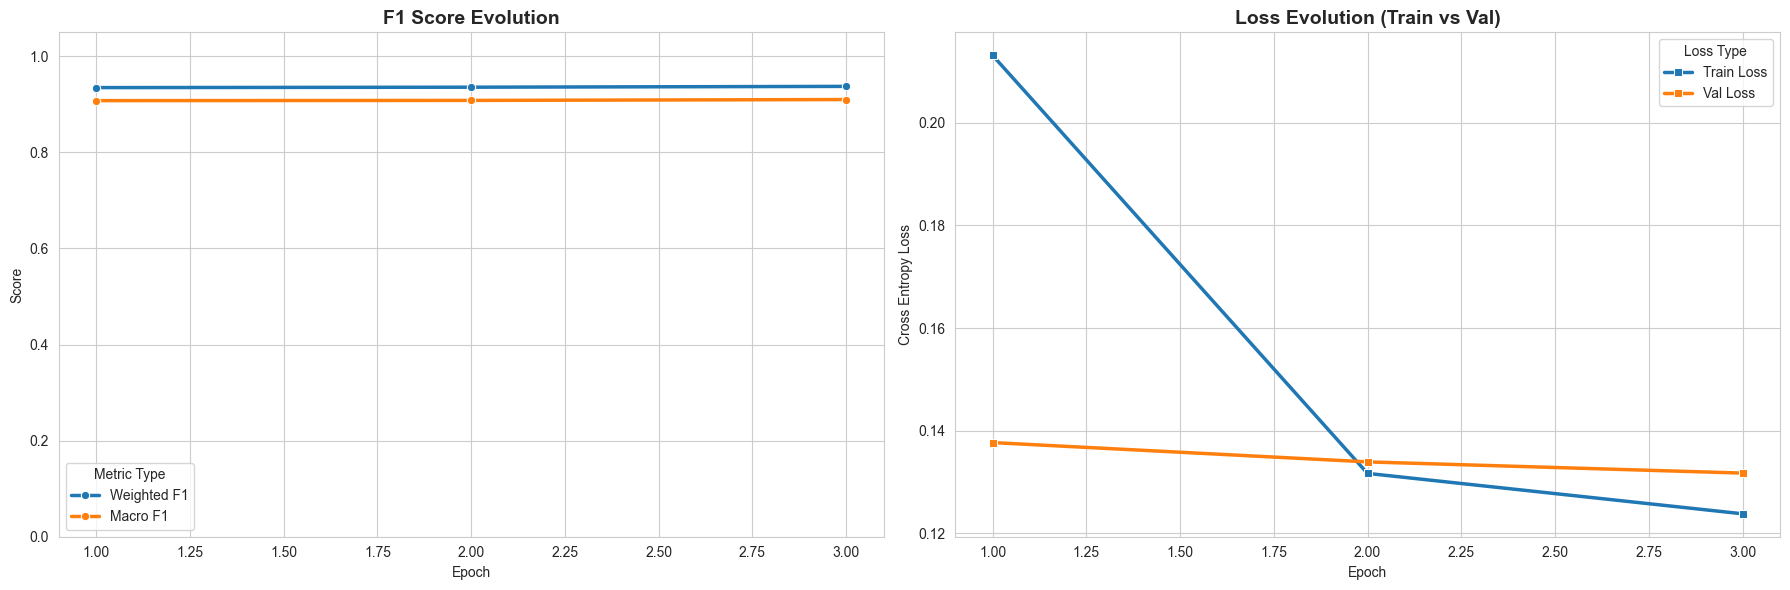

In [47]:
# Prepare data for F1
max_range = max(last_epoch+1, len(history_lstm['weighted']))
epochs = range(1, max_range)
df_f1 = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_lstm['weighted'] + history_lstm['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_lstm['train_loss'] + history_lstm['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# Plot
plt.tight_layout()
plt.show()


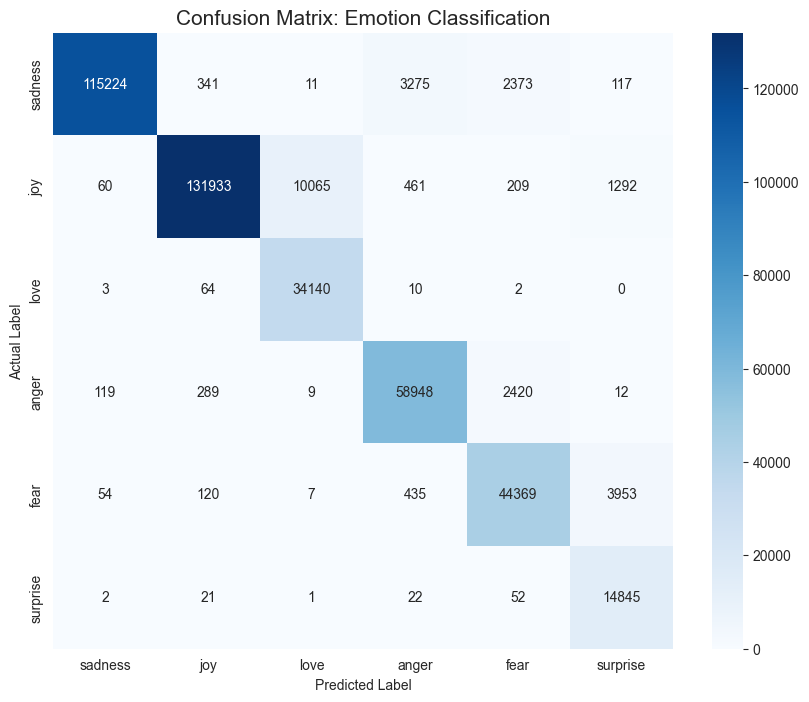

Classification Report
              precision    recall  f1-score   support

     sadness       1.00      0.95      0.97    121341
         joy       0.99      0.92      0.95    144020
        love       0.77      1.00      0.87     34219
       anger       0.93      0.95      0.94     61797
        fear       0.90      0.91      0.90     48938
    surprise       0.73      0.99      0.84     14943

    accuracy                           0.94    425258
   macro avg       0.89      0.95      0.91    425258
weighted avg       0.95      0.94      0.94    425258

0.9224238917690895


In [52]:
# Confusion Matrix

# Redefined because the output of lstm (logits,weights) is different from the baseline (only logits)
def get_all_preds(data_row, model): 
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0)

    with torch.no_grad():
      # Unpack the tuple to get logits and discard weights
      logits, _ = model(input_tensor)
      predicted_idx = torch.argmax(logits, dim=1).item()
    return predicted_idx

model_lstm.eval()
all_preds= df.apply(lambda row: get_all_preds(row, model_lstm), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)

# Classification Report
cr = classification_report(all_labels, all_preds, target_names=target_labels)
print(f"Classification Report\n{cr}")

# Matthews Correlation Coefficient (MCC)
mc = matthews_corrcoef(all_labels, all_preds)
print(mc) # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

# Class Wise Attention

In [60]:
class EmoDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(s) for s in sequences]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]
        
def get_attention_samples(model, data_loader, emotion_labels, num_samples=3):
    model.eval()
    samples = {label: [] for label in emotion_labels}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs, labels
            
            logits, weights = model(inputs)
            probs = torch.softmax(logits, dim=1)
            confidences, predictions = torch.max(probs, dim=1)

            for i in range(len(labels)):
                true_label = emotion_labels[labels[i].item()]
                pred_label = emotion_labels[predictions[i].item()]

                # Only keep if prediction is correct and we need more samples
                if true_label == pred_label and len(samples[true_label]) < num_samples:
                    samples[true_label].append({
                        'input_ids': inputs[i],
                        'weights': weights[i],
                        'confidence': confidences[i].item()
                    })

            # Stop if we have enough samples for all classes
            if all(len(v) == num_samples for v in samples.values()):
                break
    return samples


# Re-create the loader with shuffling enabled

from sklearn.model_selection import train_test_split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    df['sequences'].values,
    df['label'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=df['label'].values
)

def collate_fn(batch):
    # Sort by length (optional but helps LSTM efficiency)
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)

    # Pad sequences to the length of the longest one in this batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)

    return padded_sequences, labels

test_loader_shuff = DataLoader(
    EmoDataset(test_sequences, test_labels),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

samples = get_attention_samples(model_lstm, test_loader_shuff, target_labels, num_samples=5)

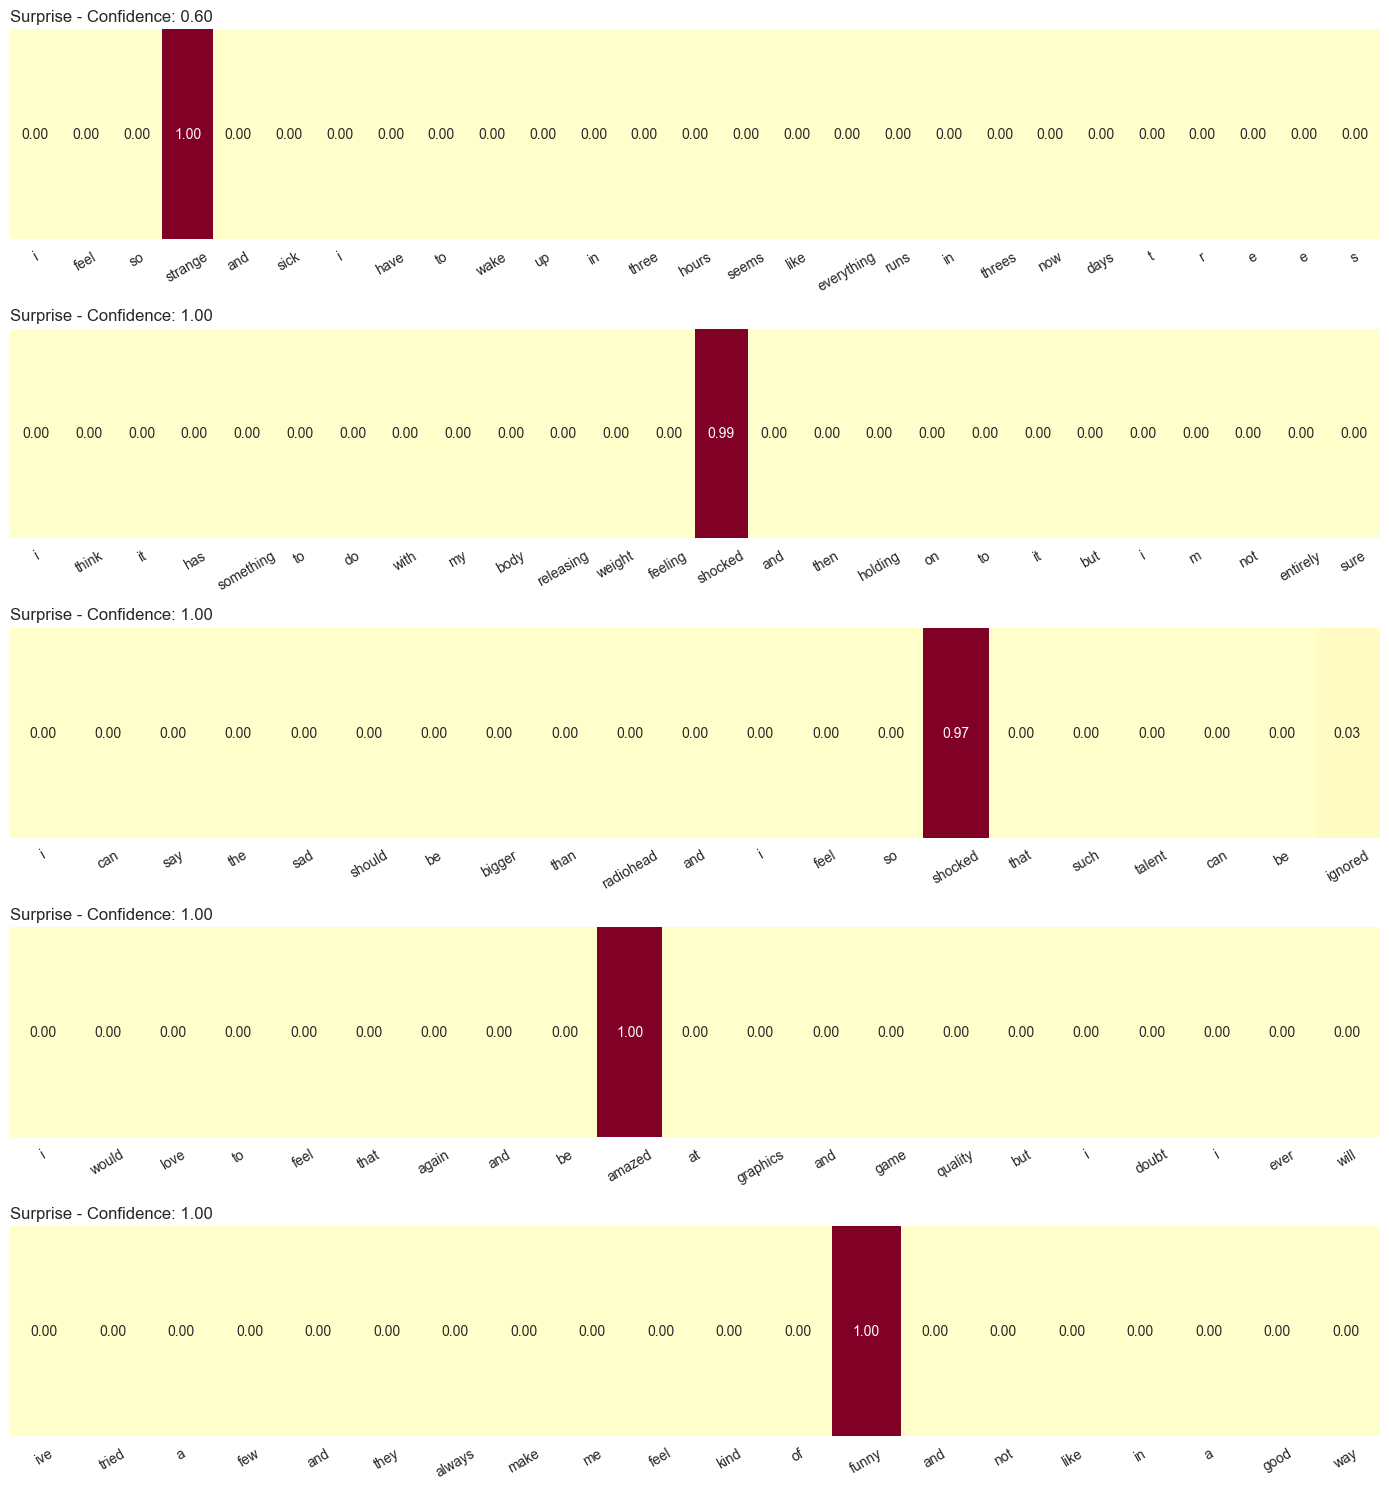

In [73]:
def plot_single_label_attention(samples_list, idx2word, label_name):
    """
    Plots a vertical stack of heatmaps for samples belonging to ONE specific label.
    """
    num_samples = len(samples_list)
    fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3 * num_samples))

    # Ensure axes is an array even if only 1 sample exists
    if num_samples == 1: axes = [axes]

    for i, sample in enumerate(samples_list): # Iterate over sample list
        ax = axes[i]

        # 1. Get IDs and Weights, filtering out Padding (index 0)
        ids = sample['input_ids'].cpu().numpy()
        weights = sample['weights'].squeeze().cpu().numpy()

        mask = ids != 0
        words = [idx2word.get(idx, '<UNK>') for idx in ids[mask]]
        valid_weights = weights[mask].reshape(1, -1) # Reshape to 2D for heatmap

        # 2. Plot Heatmap
        sns.heatmap(valid_weights, annot=True, fmt=".2f", cmap="YlOrRd",
                    xticklabels=words, yticklabels=[], cbar=False, ax=ax)

        # 3. Titles
        ax.set_title(f"{label_name} - Confidence: {sample['confidence']:.2f}", loc='left')
        ax.tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()


# Plot Attention weights for Surprise
plot_single_label_attention(samples['surprise'], idx2word, "Surprise")


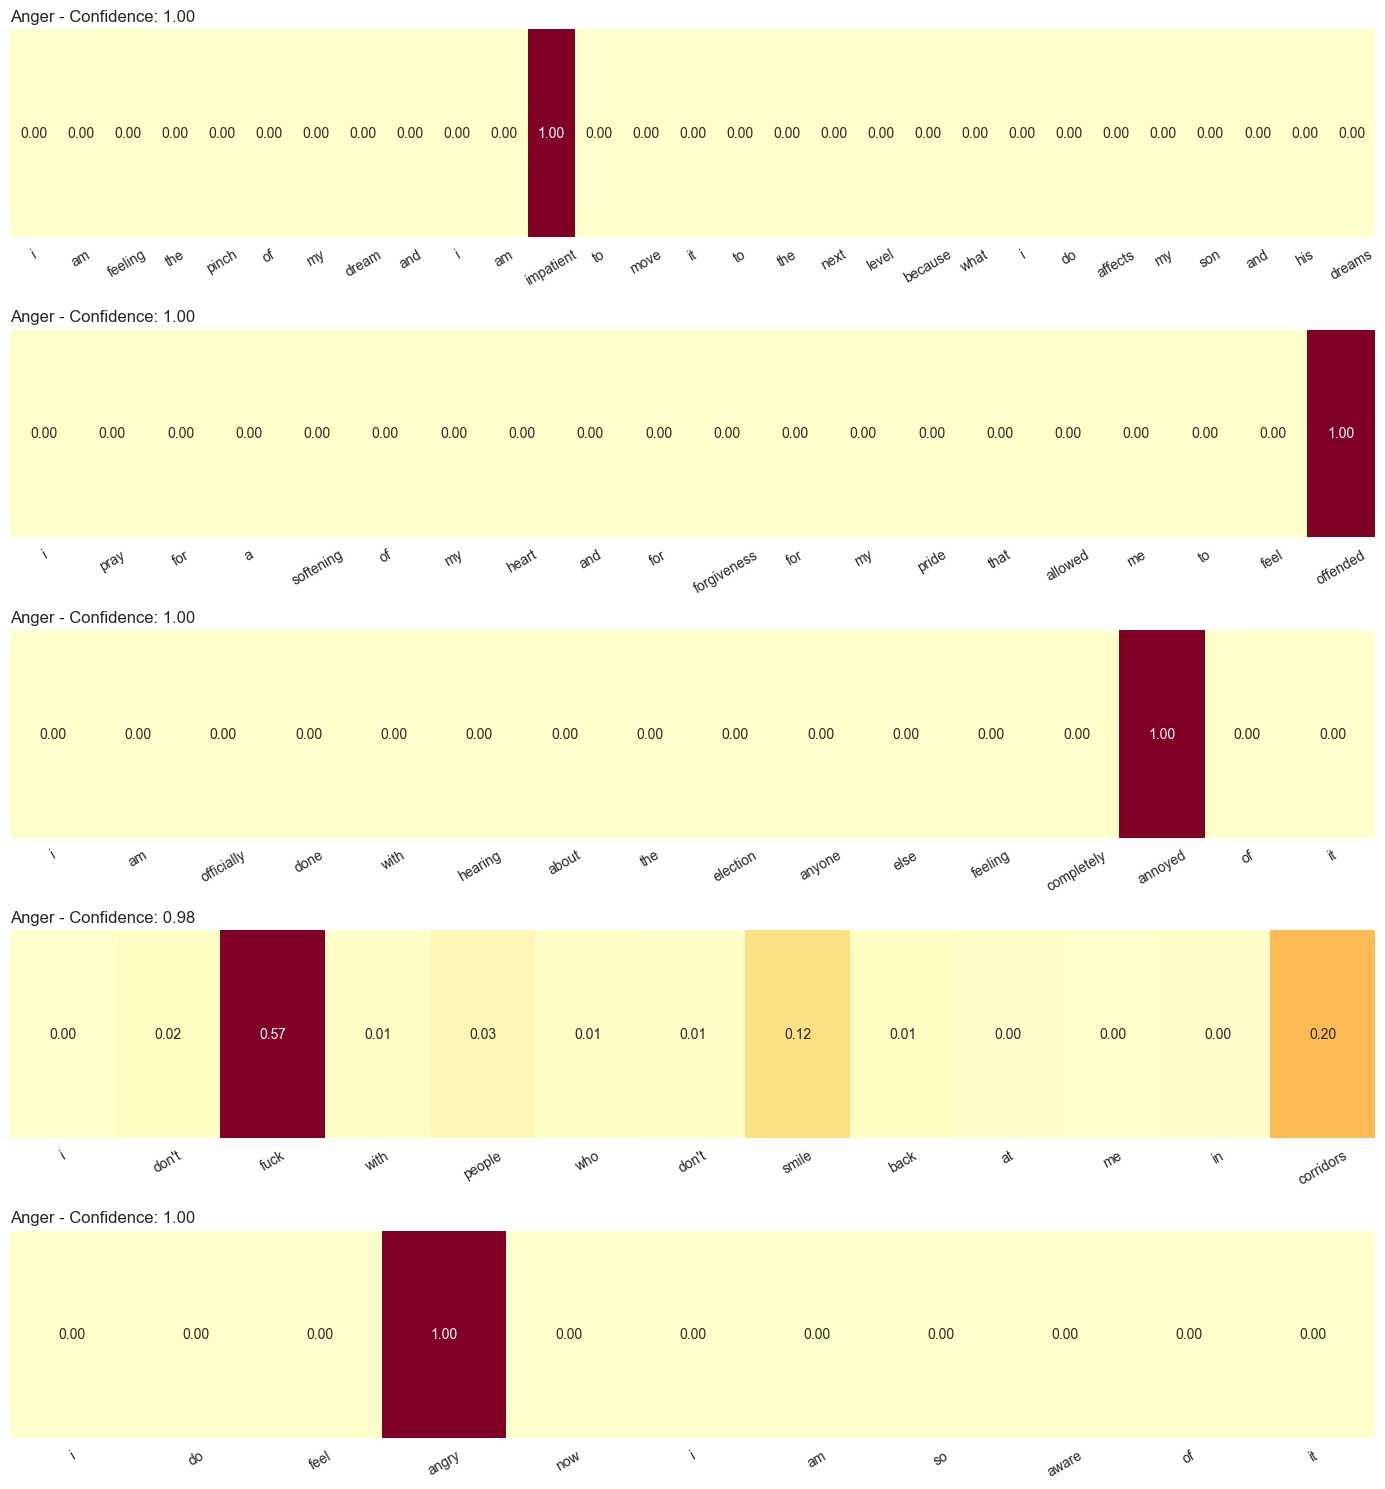

In [68]:
# Plot attention weights for Anger
plot_single_label_attention(samples['anger'], idx2word, "Anger")

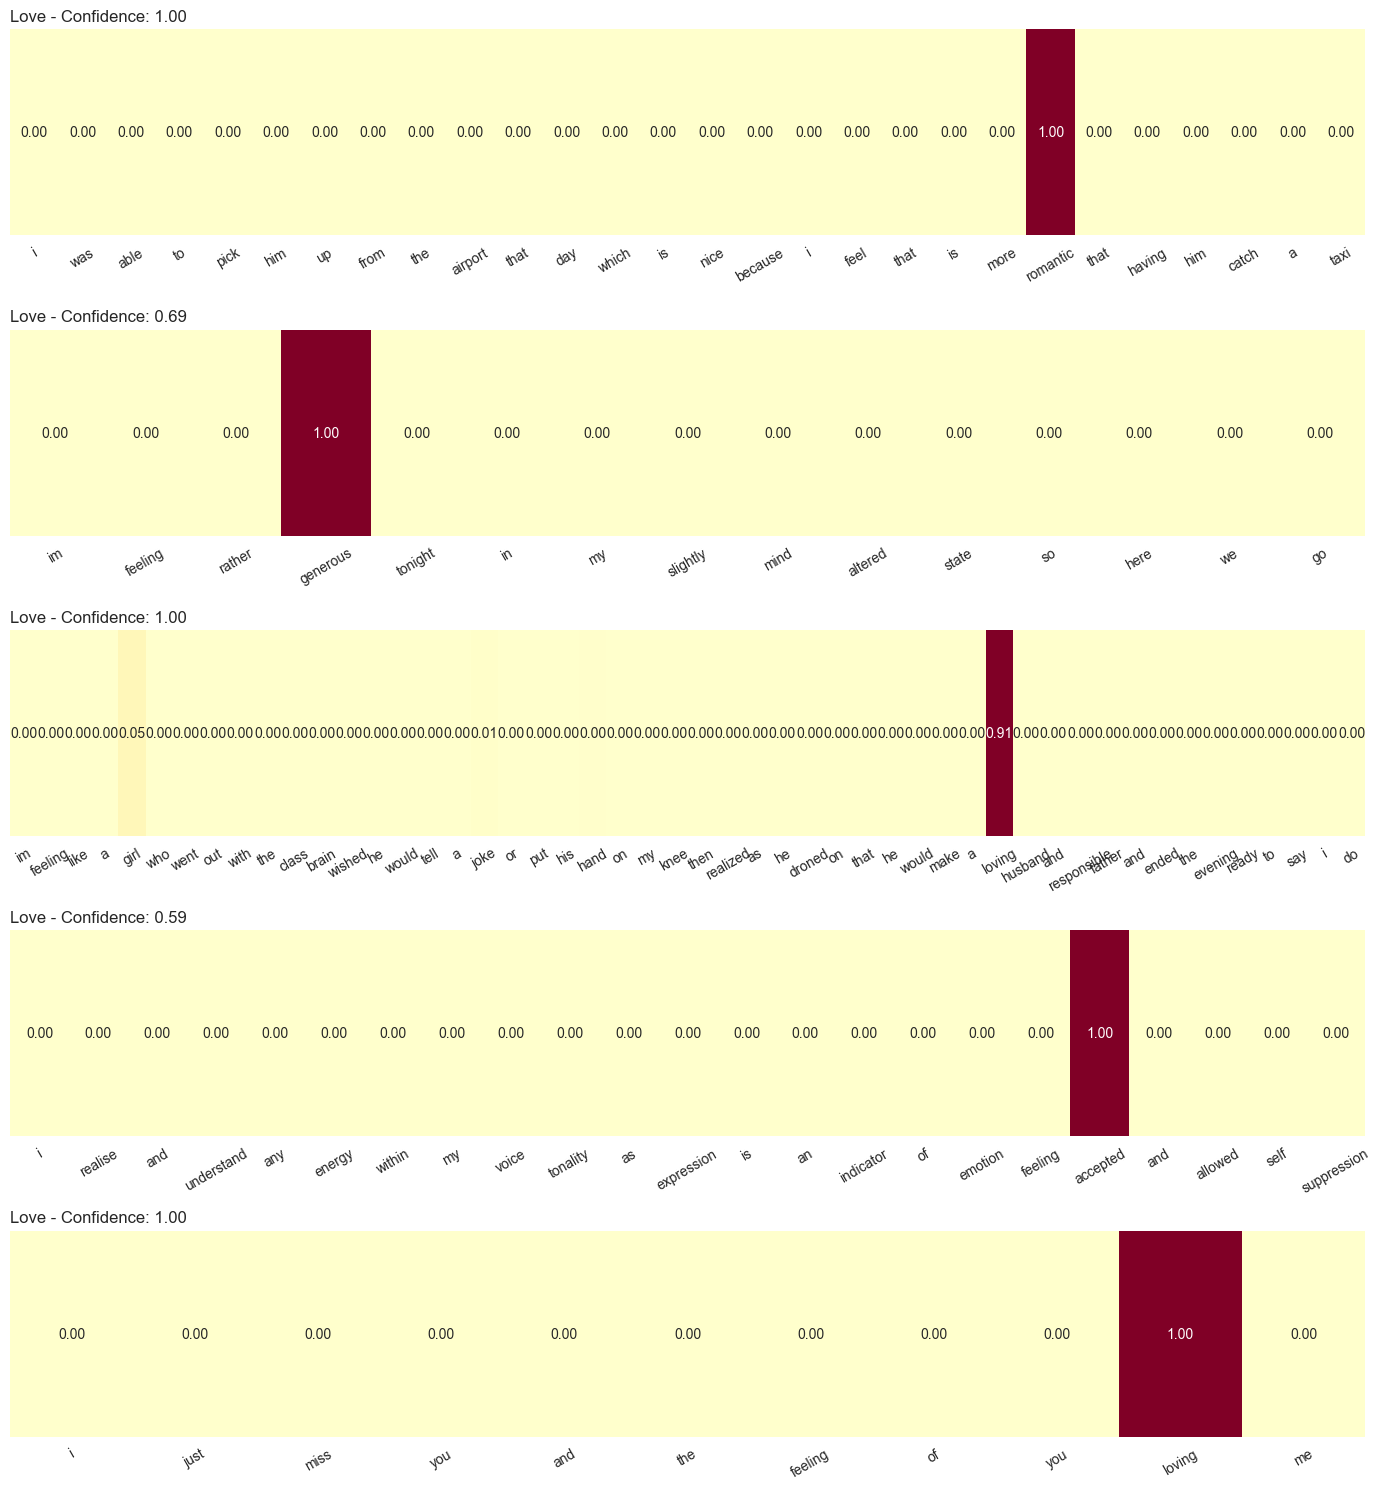

In [69]:
# Plot attention weights for love
plot_single_label_attention(samples['love'], idx2word, "Love")

Notice that some weights are close to 1 for some words associated with the labels. For example "frustrated" for anger and "strange" for surprise.

The weight for the word "frustrated" represents the word in that context of sentence. The model ignores the surrounding words to focus on the most meaningful ones.

Now i'll compute the top 5 most important words for each label over the selected samples

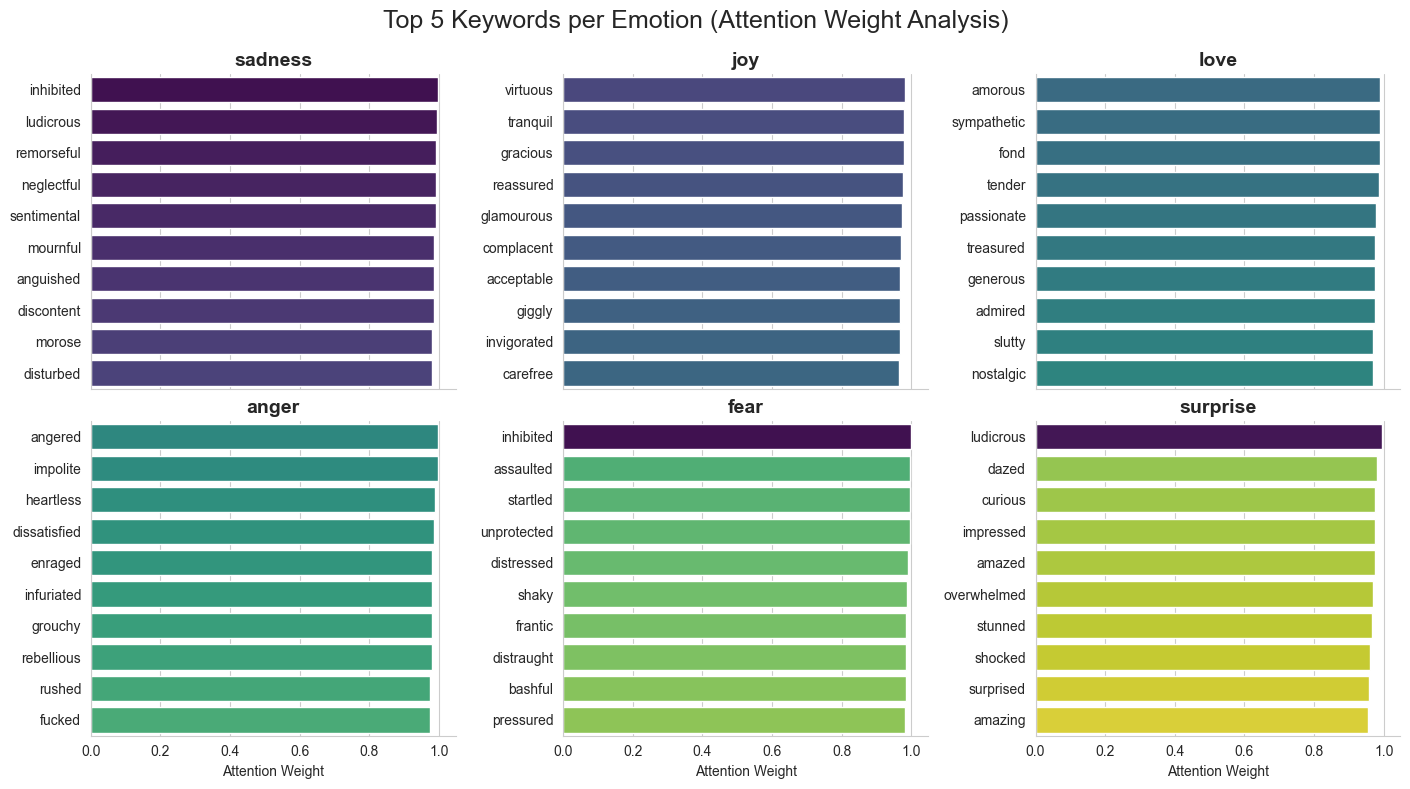

In [74]:
def get_global_word_importance(model, data_loader, idx2word, target_labels):
    model.eval()
    # Store running sum and count: {emotion: {word: [sum_weights, count]}}
    stats = {label: defaultdict(lambda: [0.0, 0]) for label in target_labels}

    with torch.no_grad():
        for inputs, labels in data_loader:
            logits, weights = model(inputs) # weights shape: [batch, seq_len, 1]

            weights = weights.squeeze(-1).cpu().numpy()
            inputs_numpy = inputs.cpu().numpy()
            labels_numpy = labels.cpu().numpy()

            for b in range(inputs_numpy.shape[0]):
                emotion = target_labels[labels_numpy[b]]
                for i, word_id in enumerate(inputs_numpy[b]):
                    if word_id == 0: continue # Skip padding

                    word = idx2word.get(word_id, '<UNK>')
                    stats[emotion][word][0] += weights[b, i] # add to sum
                    stats[emotion][word][1] += 1             # increment count

    # Calculate final averages
    summary = {}
    for emotion, word_dict in stats.items():
        avg_scores = {w: (val[0] / val[1]) for w, val in word_dict.items() if val[1] > 5} # Min frequency filter
        summary[emotion] = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    return summary

global_top_words = get_global_word_importance(model_lstm, test_loader_shuff, idx2word, target_labels) # Get top 5 words for each label


# Shows a Bar Plot of the top words for each label over the selected samples

# 1. Flatten the dictionary into a DataFrame
data_list = []
for emotion, top_words in global_top_words.items():
    for word, weight in top_words:
        data_list.append({
            'Emotion': emotion,
            'Word': word,
            'Average Weight': weight
        })

df_importance = pd.DataFrame(data_list)

# 2. Create the Faceted Bar Plot
sns.set_style("whitegrid")
g = sns.catplot(
    data=df_importance,
    kind="bar",
    x="Average Weight",
    y="Word",
    col="Emotion",
    col_wrap=3,           # Show 3 emotions per row
    palette="viridis",
    hue="Word",
    sharey=False,         # Important: each emotion has different words
    height=4,
    aspect=1.2
)

# 3. Final Polish
g.set_titles("{col_name}", size=14, fontweight='bold')
g.set_axis_labels("Attention Weight", "")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Top 5 Keywords per Emotion (Attention Weight Analysis)', fontsize=18)

plt.show()

# Inference Test and Error Analysis

In [75]:
# Test inference for base model
model_lstm.eval()

# Select a random tweet from the dataset
random_row = df.sample(1).iloc[0]
tweet = random_row['text']
true_label = random_row['emotions']

# Preprocess the tweet
indices = tweet_to_indices(tweet, word2idx)

# Convert to tensor and add batch dimension (batch_size=1)
input_tensor = torch.tensor(indices).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output, _ = model_lstm(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()
    # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
    predicted_label = id_to_emotion[predicted_idx]

# Display results
print(f"Tweet: {tweet}")
print(f"True Emotion: {true_label}")
print(f"Predicted Emotion: {predicted_label}")

NameError: name 'tweet_to_indices' is not defined

In [ ]:
id_to_emotion = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
emotion_to_id = {'sadness':0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

def tweet_to_indices(text, word2idx):
    tokens = pipeline.transform(text)
    return [word2idx.get(token, 1) for token in tokens]

# Print 10 tweets that the model didn't get correctly from the shuffled validation set
model_lstm.eval()
fails_samples = [] # Initialize as a list to store failed samples

failed_examples = df[df['label'] != all_preds]

if not failed_examples.empty:
    random_fails = failed_examples.sample(10)
    for idx, row in random_fails.iterrows():
      tweet = row["text"]
      true_label = id_to_emotion[row["label"]]

      # Perform inference
      with torch.no_grad():
        indices = row["sequences"]
        input_tensor = torch.tensor(indices).unsqueeze(0)
        # Unpack the output: get logits and discard attention weights
        logits, weights = model_lstm(input_tensor)
        predicted_idx = torch.argmax(logits, dim=1).item()
        predicted_label = id_to_emotion[predicted_idx]

        probs = torch.softmax(logits, dim=1)
        confidences, predictions = torch.max(probs, dim=1)

        fails_samples.append(
            {'tweet': tweet,
             'true_label': true_label,
             'predicted_label': predicted_label,
             'input_ids': input_tensor.squeeze(0), # Store the tensor itself, without the batch dimension
             'weights': weights, # Squeeze and convert to numpy for easier handling
             'confidence': confidences[0].item() # Access the first (and only) element for a batch size of 1
            }
        )

      print(f"Tweet: {tweet}\nTrue label: {true_label}\nPredicted Label: {predicted_label}")

Tweet: i feel that the landlord is not being considerate and somewhat taking advantage of us
True label: joy
Predicted Label: love
Tweet: i can see the reason why i am here and i can see the reason why things happened in the past and i am very thankful to be where i am i feel blessed to have my family and friends around me they are my support system
True label: joy
Predicted Label: love
Tweet: #Partners are willing to #walk alongside you without being #intimidated by you. #WhoIsIT #Part2 #RelationShift #CLifeMacon
True label: joy
Predicted Label: anger
Tweet: im just feeling a bit stressed or actually a lot stressed because tomorrow is fathers day
True label: sadness
Predicted Label: anger
Tweet: loneliness
True label: sadness
Predicted Label: joy
Tweet: At school, my classmate is with me at music class and he sang Hallelujah like, god, with my friend we were breathless.
True label: joy
Predicted Label: anger
Tweet: i have taken several moments throughout our busy day to be thankful an

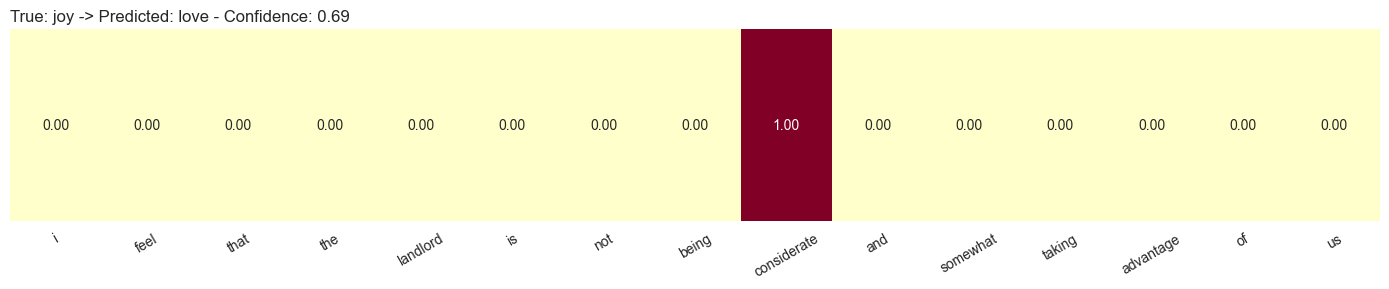

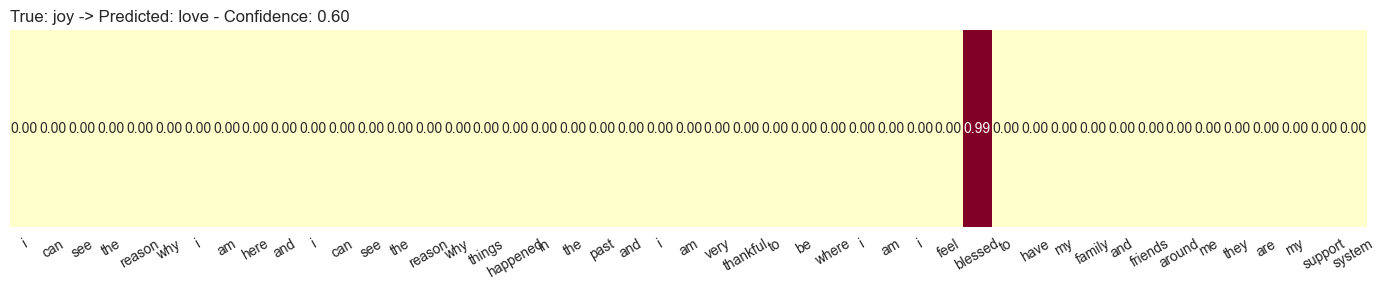

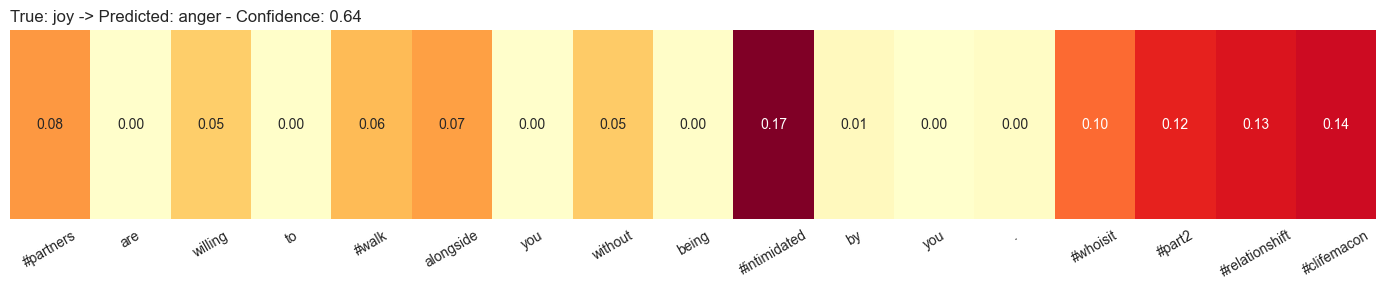

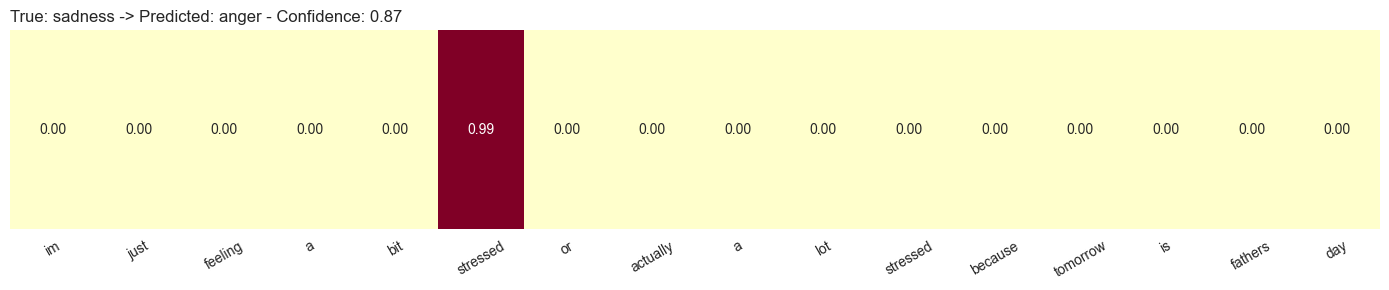

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

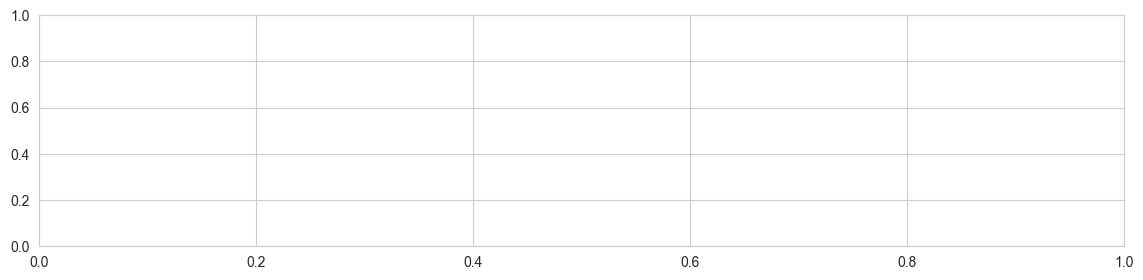

In [85]:
# Plot the attention weights for 10 samples
if fails_samples:
    # Use the plot_single_label_attention function to visualize each failed sample
    for sample in fails_samples:
        plot_single_label_attention(
            [sample], # Pass as a list of one sample
            idx2word,
            f"True: {sample['true_label']} -> Predicted: {sample['predicted_label']}"
        )

In the following cell i used the model to inference on some sarcastic tweets taken from this Kaggle dataset: https://www.kaggle.com/datasets/nikhiljohnk/tweets-with-sarcasm-and-irony/data

The model wasn't trained to distinguish sarcastics tweet. The dataset may probably contains some sarcastic text by the nature of the source (people online love to use sarcasm).

On the selected samples (unseen by the model), in some cases, the model predicted the correct emotion.

5 Samples are too few to provide a good statistical prove of the capability of the model to recognize emotion despite sarcasm.

In [90]:
# Test with a sarcastic tweet
tweets= ["I love mondays, they are my favorite day! Totally not stressful at all",
         "I just love getting anxiety at random times. Its fun",
         "I'm having a SUPER great night 😡 #sarcasm #perksofhavingadog",
         "My stomach hurts from laughing so much",
         "My grandfather's in the hospital today. #GrandparentsDay #irony Pray for him.",
         "I just love people who throw toilet paper everywhere in public bathrooms. Janitors are def hired just for you. #sarcasm"
         ]

for tweet in tweets:
  indices = tweet_to_indices(tweet, word2idx)
  input_tensor = torch.tensor(indices).unsqueeze(0)

  # Perform inference
  with torch.no_grad():
     output,_ = model_lstm(input_tensor)
     predicted_idx = torch.argmax(output, dim=1).item()
     # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
     predicted_label = id_to_emotion[predicted_idx]

  # Display results
  print(f"Tweet: {tweet}\nPredicted Emotion: {predicted_label}\n{"-"*50}")


Tweet: I love mondays, they are my favorite day! Totally not stressful at all
Predicted Emotion: joy
--------------------------------------------------
Tweet: I just love getting anxiety at random times. Its fun
Predicted Emotion: joy
--------------------------------------------------
Tweet: I'm having a SUPER great night 😡 #sarcasm #perksofhavingadog
Predicted Emotion: joy
--------------------------------------------------
Tweet: My stomach hurts from laughing so much
Predicted Emotion: joy
--------------------------------------------------
Tweet: My grandfather's in the hospital today. #GrandparentsDay #irony Pray for him.
Predicted Emotion: anger
--------------------------------------------------
Tweet: I just love people who throw toilet paper everywhere in public bathrooms. Janitors are def hired just for you. #sarcasm
Predicted Emotion: anger
--------------------------------------------------


# Limitations
1. Model wasn't trained to consider sarcasm
2. Short tweets i.e responses (<5 words) may lack context
3. Model trained on English tweets only
4. No multi-label support (tweets with mixed emotions)
5. Internet slang evolves rapidly, this may degrade performance on very recent slang not present in training data
6. Despite weighted cross-entropy loss, the minority classes (surprise, fear) predictions show lower F1-scores

## Future Improvements:
- Scrape more data to balance classes distribution
- Sarcasm detection module
- Multi-label support i.e a tweet that is both sad and angry
- Consider more labels
- Cross-lingual transfer: train and test on non-English tweets with multilingual models
- Consider using a more powerful embedding layer i.e based on BERT/RoBERTa and a transformer